<a href="https://colab.research.google.com/github/jdvala/Thesis/blob/master/LSTM_DE_32_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bidirectional LSTM for Geman with 32 classes

The bidirectional LSTM is trained on sentence level and there are two evaluations, one on sentence level and one on document level

In [0]:
# Imports
import os
import keras
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Embedding as emb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn
from keras.utils import generic_utils 
from sklearn.preprocessing import LabelEncoder


# Setting seed to get reproducable results
from numpy.random import seed
from tensorflow import set_random_seed
SEED = 13
seed(SEED)
set_random_seed(SEED)

# For displaying the whole conf matrix
np.set_printoptions(threshold=np.nan)




## Setting Up Google Drive
The data used in this notebook is available in my drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#embding_path = '/content/gdrive/My Drive/en.de.context.emb'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Getting the data

The data is pickled and hence unpickling it here.


In [0]:
# unpickle data
import pickle
def unpickle(obj):
    with open(obj, 'rb') as picklehandle:
        toReturn = pickle.load(picklehandle)
    return toReturn

en_de_combined = unpickle('/content/gdrive/My Drive/combined_data.pkl')
label = unpickle('/content/gdrive/My Drive/en-de-label.pkl')

## Test Train Split

Before doing anything, Split the data into test and train sets, so there is no information leak from train data to test data.
This is not a problem in case of one language as every instance is either in train or test set, but in case of multilingual data it might so happen that a document from one language is in  train set and the same document from another language might end up in test set, this might be a problem, and to avoid it we split the data as soon as we have it.

In [0]:
# Initial Test Train Split
train_data, test_data, train_la, test_la = train_test_split(en_de_combined, label,test_size=0.3, random_state=SEED)

## Seperate the data

As mentioned above there is a slight chance that the information leak might happen. Hence during curation of the data, **English** and **German** data as well as their document id(manually generated), file names, multiple labels and thier labels were combined in a single list with *'\n\n\n'*(three new line characters). This was done to ensure there is no information loss what so ever.

In [0]:
def seperate_data(data, label):
    """Seperates data from combined data, it is seperated by '\n\n\n', three new line charaters
    Returns: english data, german data, file name, doc_id, multiple labels
    """
    en_data = [] 
    de_data = []
    file_name = []
    doc_id = []
    multilabel = []
    labels = []
    
    if isinstance(data, list):
        for doc, l in zip(data,label):
            en_data.append(doc.split('\n\n\n')[0])
            de_data.append(doc.split('\n\n\n')[1])
            file_name.append(doc.split('\n\n\n')[2])
            doc_id.append(doc.split('\n\n\n')[3])
            multilabel.append(doc.split('\n\n\n')[4])
            labels.append(l)
    return en_data,de_data, file_name, doc_id, multilabel, labels
    

In [0]:
# Seperating train and test data
train_en_data,train_de_data, train_file_name, train_doc_id, train_multilabel, train_label = seperate_data(train_data, train_la)

test_en_data,test_de_data, test_file_name, test_doc_id, test_multilabel, test_label = seperate_data(test_data, test_la)

## Sliding Window

Sliding window, helper function to chunk the incoming document into predefined chuck length and step size

In [0]:
def slidingWindow(sequence,winSize,step):
    """Returns a generator that will iterate through
    the defined chunks of input sequence. Input sequence
    must be sliceable."""

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
    # Do the work
    for i in range(0,round(numOfChunks)*step,step):
        yield sequence[i:i+winSize]

## Numbering Labels

Manually labeling the alpha labels as the evaluation based on documents will require more control over the label  

In [9]:
# Numbering the labels
label_num = dict(enumerate(sorted(set(label))))
print(label_num)

{0: 'agriculture', 1: 'audiovisual_and_media', 2: 'budget', 3: 'competition', 4: 'consumers', 5: 'culture', 6: 'customs', 7: 'development', 8: 'economic_and_monetary_affairs', 9: 'education_training_youth', 10: 'employment_and_social_policy', 11: 'energy', 12: 'enlargement', 13: 'enterprise', 14: 'environment', 15: 'external_relations', 16: 'external_trade', 17: 'fight_against_fraud', 18: 'food_safety', 19: 'foreign_and_security_policy', 20: 'human_rights', 21: 'humanitarian_aid', 22: 'information_society', 23: 'institutional_affairs', 24: 'internal_market', 25: 'justice_freedom_security', 26: 'maritime_affairs_and_fisheries', 27: 'public_health', 28: 'regional_policy', 29: 'research_innovation', 30: 'taxation', 31: 'transport'}


## Train Sentence preparation German

From the training documents we are creating sentences and the giving them corresponding numeric labels to each sentence

In [10]:
# Train data preparation
_train_sentence = []
_train_label = []

for doc, labe in zip(train_de_data, train_label):
    # call the sliding window on doc
    
    slides = slidingWindow(doc.split(' '), 30, 10)
    
    # get the num label 
    for key, value in label_num.items():
        if value == labe:
            num = key
            
      
    for slide in slides:
        _train_sentence.append(slide)
        _train_label.append(num)


# ensuring the number of samples in train set and labels
print(len(_train_sentence), len(_train_label))

137319 137319


## Tokenizing training sentence

Toknizing the training sentences and then fitting it on train sentence and then use the same tokenizer object on test data
Also calculate the vocabulary size which we will need in the embedding layer. 

In [11]:
# tokenizing Sentences Using Keras tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()

# Tokenizing the sentences (This process may take some time depending on your corpus size)
tokenizer.fit_on_texts(_train_sentence)

# Lets see what our vocabulary size is
vocab_size = len(tokenizer.word_index) + 1   # We are adding 1 here because it takes indexing from zero
print("Vocabulary size is: {}".format(vocab_size))

# Sentence encoding (it means we are now converting words into numbers)
sent_encoded = tokenizer.texts_to_sequences(_train_sentence)
print("The number of sentence in train set after encoding: {}".format(len(sent_encoded)))


# Start padding with the 30, although we wont need it, but still as precautionary measure
max_len = len(_train_sentence[1])
print('Maximum length of sentences in training set is', max_len)
padded_sents = keras.preprocessing.sequence.pad_sequences(sent_encoded, maxlen=max_len, padding='post')

Vocabulary size is: 52239
The number of sentence in train set after encoding: 137319
Maximum length of sentences in training set is 30


## One Hot Encoding Labels

The numerical labels needs to be converted into its one hot encoded form.

In [0]:
# Converting train labels into one hot encoded form
oht_obj = OneHotEncoder(sparse=False, categories='auto')
oht_obj.fit((np.reshape(_train_label, (-1,1))))

train_labels = oht_obj.transform((np.reshape(_train_label, (-1,1))))


## Callback

Two call backs are used here,

* *reduce_rate*:  Which helps in situation where we are stuck on a Plateau.
* *early_stopping*: It monitors the validation loss and in case of overfitting it will wait for the number of epochs given by user before stopping the leanring process.


In [0]:
# Other callbacks 
reduce_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0, verbose=1, 
                                                mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=2, verbose=1, mode='auto')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.




## Model Architecture

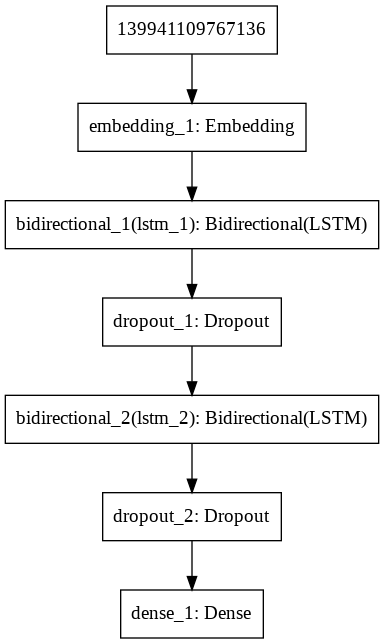

In [0]:
from IPython.display import Image
Image('/content/model.png')

In [0]:
# Create sequential model
model = Sequential()
model.add(emb(vocab_size, 200, input_length=max_len))   
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.04))))# LSTM layer 
model.add(keras.layers.Dropout(0.5))
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.03))))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(32, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 200)           10447800  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 80)            77120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80)                38720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2592      
Total params: 10,566,232
Tr

In [0]:
# Model visualization
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
# Training the mdoel
model.fit(padded_sents, train_labels, validation_split=0.3, epochs=20, batch_size=32, 
          verbose=1, callbacks=[reduce_rate,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 96123 samples, validate on 41196 samples
Epoch 1/20
96123/96123 [==============================] - 621s 6ms/step - loss: 3.2347 - acc: 0.1343 - val_loss: 3.0669 - val_acc: 0.1444
Epoch 2/20
96123/96123 [==============================] - 617s 6ms/step - loss: 2.5827 - acc: 0.2375 - val_loss: 2.9153 - val_acc: 0.1770
Epoch 3/20
96123/96123 [==============================] - 620s 6ms/step - loss: 2.3175 - acc: 0.3182 - val_loss: 2.8461 - val_acc: 0.2313
Epoch 4/20
96123/96123 [==============================] - 626s 7ms/step - loss: 2.0738 - acc: 0.4089 - val_loss: 2.8420 - val_acc: 0.2528
Epoch 5/20
96123/96123 [==============================] - 636s 7ms/step - loss: 1.8633 - acc: 0.4817 - val_loss: 2.7845 - val_acc: 0.2990
Epoch 6/20
96123/96123 [==============================] - 1112s 12ms/step - loss: 1.7029 - acc: 0.5437 - val_loss: 2.7173 - val_acc: 0.3316
Epoch 7/20
96123/96123 [==============================] - 1122s 12ms/ste

In [0]:
# Saving the model
model.save('/content/gdrive/My Drive/Thesis Models/DE_32_CLASS_LSTM.h5')

## Evaluation on Document level

SVMs are trained on document level and to make a fair evaluation the LSTMs needs to be evaluated on document level as well, but LSTM are trained on sentence level as due to hardware limitations one can not feed the whole document hence the technique used here is a little unique. 

So to make a fair comparision, the evaluation has to be done manually, first the document has to be divided into sentences with same technique used during training, then when all the sentence from a single document is curated then they are encoded into numeric form and padded to make all of them of equal length.

Then each sentence is predicted and the predictions are normalized and combined to make it a single prediction for the whole document.



In [2]:
# Loading the model for evaluation
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/Thesis Models/DE_32_CLASS_LSTM.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

original_label = []   # list to store the original label 
predicted_label = []   # list to store the predicted label

for first_data, first_label in zip(test_de_data,test_label):
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in label_num.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        
        a = ' '.join(slide)
        
        doc_sent.append(a)
    
        
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer.texts_to_sequences(doc_sent)

    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')


    # predict the label
    sent_pred.append(model.predict(text_padded))        
    
    # normailizing the predictions before combining them.
    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    # adding all the predictions of sentences of a single document into one.
    sent = np.zeros(32)
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    # populating lists of the predicted labels and original labels for further evaluation
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)
    
    

In [0]:
test_label[1:10]

In [0]:
# Accuracy on document level
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy of the model on document level is: {:.2f} %".format(accuracy_score(original_label, predicted_label)*100))

Accuracy of the model on document level is: 65.40 %


In [0]:
# Classification report and confusion Matrix
np.set_printoptions(threshold=np.nan)
print(confusion_matrix(original_label, predicted_label))

[[20  0  0  0  1  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  0
   0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2
   0  1  0  0  2  3  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0  0  0  5]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  1
   7  2  0  0  0  1  0  1]
 [ 0  0  0  0  0  2  0  0  0  1  0  0  1  1  0  1  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  7  0  0  0  1  0  0  1  1  0  1  0  0  0  0  0  0  0
   0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 41  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 22  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3  0  0  0 

In [0]:
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77        25
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        10
           3       1.00      0.33      0.50        15
           4       0.59      0.62      0.61        37
           5       0.67      0.29      0.40         7
           6       0.64      0.47      0.54        15
           7       0.68      0.94      0.79        18
           8       0.93      0.95      0.94        43
           9       0.69      0.85      0.76        26
          10       0.69      0.87      0.77        47
          11       0.81      0.61      0.69        28
          12       0.56      0.56      0.56        16
          13       0.14      0.23      0.17        13
          14       0.59      0.80      0.68        44
          15       0.57      0.36      0.44        22
          16       0.64      0.64      0.64        14
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Evaluation on Sentence level


In [0]:
# converting docs into sentences and corresponding numerical labels
_test_sentences = []
_test_label_alpha = []
_test_label_num = []

for _t_data, t_label in zip(test_de_data, test_label):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(_t_data.split(' '),30,10)
        
    for key,value in label_num.items():
        if value == t_label:
            num = key
    
    
    for slide in slides:
        _test_sentences.append(' '.join(slide))
        _test_label_alpha.append(t_label)
        _test_label_num.append(num)

In [14]:
len(_test_sentences), len(_test_label_alpha), len(_test_label_num)

(59448, 59448, 59448)

In [15]:
# Coverting labels to one hot encoded format
test_label = oht_obj.transform(np.reshape(_test_label_num,(-1,1)))
print(len(_test_label_num))

59448


In [16]:
set(_test_label_num)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31}

In [0]:
#Test sentences to numeric converstion
test_sequences = tokenizer.texts_to_sequences(_test_sentences)
padded_sents_test = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post')

In [18]:
print(len(padded_sents_test))

59448


In [19]:
scores = model.evaluate(padded_sents_test, test_label, verbose=1)
print("Accuracy on sentence level: %.2f%%" % (scores[1]*100))

59448/59448 [==============================] - 41s 697us/step
Accuracy on sentence level: 35.61%


In [0]:
pred = model.predict(padded_sents_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(test_label, axis=1)


In [23]:
print(confusion_matrix(y_true, y_pred))

[[ 963    0    4    5  100    0    5   41   34   10   47   36   48   62
   475   16   61    4  126    0    1    0   32   32   50   24  240   52
    84   56   16  134]
 [   1    3    0    1    8   83   57    0    5   14   11    1    4   24
    10    6    2    2    9    1   11    0   95   10   22   29    1    8
     4    3    1   12]
 [  23    0   20    1    1    1    6   56   38   20   24   17    9   55
    45   19   37    7    1    0    5    3   10   56   11   38    7   13
    88   70   16   13]
 [  18    0    0   88   12    1    3    0   12    2   20   83   12  157
   115    2   12    2    1    0    0    0   27   56   76   24   49   23
    21   14    6  191]
 [  80    0    0    2  694    0    4   11   13   15   50   17    2   52
    75    1    7    0  104    0    3    0  169   69  298   79   57   28
    12   18    1  205]
 [   0    0    0    0    1   60   12    8    6   34   13    5   30   12
    10   27   12    5    3   22   20    6   23   20    2   50    0    7
    10    7    1    3

In [25]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.35      0.39      2758
           1       0.38      0.01      0.01       438
           2       0.25      0.03      0.05       710
           3       0.32      0.09      0.14      1027
           4       0.34      0.34      0.34      2066
           5       0.23      0.15      0.18       409
           6       0.38      0.25      0.30      1212
           7       0.37      0.41      0.39      1239
           8       0.72      0.74      0.73      4294
           9       0.46      0.60      0.52      1887
          10       0.37      0.47      0.41      3167
          11       0.25      0.24      0.25      1662
          12       0.27      0.24      0.25      1517
          13       0.05      0.16      0.08       822
          14       0.24      0.34      0.28      2570
          15       0.19      0.13      0.16      1753
          16       0.19      0.27      0.22       893
          17       0.02    